In [1]:
import maboss
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import sys
import yaml
import numpy as np
sys.path.append("/Users/emilieyu/endotehelial-masboss")

ipylab module is not installed, menus and toolbar are disabled.


In [2]:
from boolean_models.analysis import (
    compute_delta,
    classify_phenotype,
    save_df_to_csv
)
from boolean_models.scripts.run_perturbations import run_perturbations


In [3]:

PROJECT_ROOT = Path("/Users/emilieyu/endotehelial-masboss/")
CONFIG_PATH = PROJECT_ROOT / "config" / "rho_sim_config.yaml"

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

# Resolve Paths
MODELS_BND = PROJECT_ROOT / config['paths']['model_bnd']
MODELS_CFG = PROJECT_ROOT / config['paths']['model_cfg']
RESULTS_DIR = PROJECT_ROOT / config['paths']['results_base']
PARAM_DIR = RESULTS_DIR / config['paths']['subdirs']['param_sweep']

# Result subdirectories
RAW_DIR = RESULTS_DIR / config['paths']['subdirs']['raw']
PROCESSED_DIR = RESULTS_DIR / config['paths']['subdirs']['processed']
SS_DIR = RESULTS_DIR / config['paths']['subdirs']['steady_state']

# Global variable
PERBS_DICT = config.get('perturbations') # get mutations directly from config
N_RUNS=100
EPS = config["analysis"]["eps"]  # should be 0.25

## Testing different cfg settings

In [4]:
PROJECT_ROOT = Path("/Users/emilieyu/endotehelial-masboss/")
CONFIG_PATH = PROJECT_ROOT / "config" / "rho_sim_config.yaml"

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

# Resolve Paths
MODELS_BND = PROJECT_ROOT / config['paths']['model_bnd']

#model_cfg1 = PROJECT_ROOT / 'data' / 'models' / 'rho_v1.cfg'
model_cfg2 = PROJECT_ROOT / 'data' / 'models' / 'rho_v2.cfg'



In [5]:
m2 = maboss.load(str(MODELS_BND), str(model_cfg2))
m2.get_initial_state()

{'DSP': [0, 1], 'TJP1': [0, 1], 'JCAD': [0, 1], 'RhoA': [0, 1], 'RhoC': [0, 1]}

In [6]:
perb_df = run_perturbations(m2)

DEUBG: Loaded base MaBoSS model
DEUBG: Built result directories.
DEBUG: Running scenario: WT
DEBUG: Computing delta = RhoC - RhoA
DEBUG: Running scenario: DSP
DEBUG: Computing delta = RhoC - RhoA
DEBUG: Running scenario: TJP1
DEBUG: Computing delta = RhoC - RhoA
DEBUG: Running scenario: JCAD
DEBUG: Computing delta = RhoC - RhoA
DEBUG: Running scenario: DSP_JCAD
DEBUG: Computing delta = RhoC - RhoA
DEBUG: Running scenario: TJP1_JCAD
DEBUG: Computing delta = RhoC - RhoA
DEBUG: All simulations completed successfully
DEBUG: File perturbation_timeseries.csv successfully written to directory: /Users/emilieyu/endotehelial-masboss/results/boolean_models/perturbation_sim


In [8]:
perb_df.tail(5)



,t,DSP,TJP1,JCAD,RhoA,RhoC,perturbation,delta,phenotype
235,3.5,1.0,0.0,0.0,0.789609,0.334520,TJP1_JCAD,-0.455089,Failed
236,3.6,1.0,0.0,0.0,0.788519,0.333023,TJP1_JCAD,-0.455496,Failed
237,3.7,1.0,0.0,0.0,0.791939,0.330067,TJP1_JCAD,-0.461872,Failed
238,3.8,1.0,0.0,0.0,0.791713,0.329062,TJP1_JCAD,-0.462651,Failed
239,3.9,1.0,0.0,0.0,0.793081,0.330266,TJP1_JCAD,-0.462815,Failed


Config settings: 

perturbations:
  WT:  
    DSP: "ON"
    TJP1: "ON"
    JCAD: "ON"
  DSP: 
    DSP: "OFF"
    TJP1: "ON"
    JCAD: "ON"
  TJP1: 
    DSP: "ON"
    TJP1: "OFF"
    JCAD: "ON"
  JCAD:
    DSP: "ON"
    TJP1: "ON"
    JCAD: "OFF"
  DSP_JCAD: 
    DSP: "OFF"
    TJP1: "ON"
    JCAD: "OFF"
  TJP1_JCAD: 
    DSP: "ON"
    TJP1: "OFF"
    JCAD: "OFF"

give completely different results from: 

perturbations:
  WT:  {}
  DSP: 
    DSP: "OFF"
  TJP1: 
    TJP1: "OFF"
  JCAD:
    JCAD: "OFF"
  DSP_JCAD: 
    DSP: "OFF"
    JCAD: "OFF"
  TJP1_JCAD: 
    TJP1: "OFF"
    JCAD: "OFF"

## Sensitivity Analysis: Exploratory

In [9]:
base_model = maboss.load(str(MODELS_BND), str(MODELS_CFG))
sweep_cfg = config['sensitivity_analysis']
sweep_cfg[1:2]

[{'parameter': '$RhoA_mod',
  'range': [1.0, 8.0],
  'steps': 2.0,
  'scale': 'linear'}]

In [11]:
# WT Sensitivity analysis for each parameter
result = []
for param_cfg in sweep_cfg[0:1]:
    name = param_cfg['parameter']
    print(f"DEBUG: Running sweep for paraneter: {name}")

    values = np.arange(param_cfg['range'][0], param_cfg['range'][1], param_cfg['steps'])

    for val in values: 
        m = base_model.copy()
        m.update_parameters(**{name: val})
        #print(m.param[name])

        res = m.run()
        ss_df = res.get_last_nodes_probtraj()

        ss_df['delta'] = compute_delta(ss_df, config)
        ss_df['param_value'] = val
        ss_df['param_name'] = name
        

        result.append(ss_df)

combined_df = pd.concat(result, ignore_index=True)
save_df_to_csv(combined_df, PARAM_DIR, "wt_param_sweep_01.csv")


DEBUG: Running sweep for paraneter: $RhoA_amp
DEBUG: File wt_param_sweep_01.csv successfully written to directory: /Users/emilieyu/endotehelial-masboss/results/boolean_models/param_sweep


In [12]:
test_df = combined_df[combined_df['param_name'] =='$RhoA_amp']
test_df

,DSP,JCAD,RhoA,RhoC,TJP1,delta,param_value,param_name
0,0.490400,0.494100,0.564441,0.608958,0.500301,0.044517,5.0,$RhoA_amp
1,0.504299,0.497800,0.589074,0.606261,0.509999,0.017187,10.0,$RhoA_amp
2,0.502501,0.491300,0.609034,0.586839,0.501600,-0.022195,15.0,$RhoA_amp
3,0.504901,0.499000,0.615362,0.589883,0.496201,-0.025479,20.0,$RhoA_amp
4,0.497599,0.500200,0.615257,0.595352,0.512400,-0.019905,25.0,$RhoA_amp
5,0.495900,0.495000,0.614085,0.599620,0.501300,-0.014465,30.0,$RhoA_amp
6,0.485800,0.507300,0.623727,0.589782,0.499900,-0.033945,35.0,$RhoA_amp
7,0.504899,0.495600,0.619527,0.585180,0.503200,-0.034347,40.0,$RhoA_amp
8,0.507899,0.498198,0.620005,0.597639,0.503199,-0.022366,45.0,$RhoA_amp
9,0.491298,0.499998,0.631026,0.584366,0.503200,-0.046660,50.0,$RhoA_amp


In [13]:

test_df['phenotype'] = test_df['delta'].apply(lambda x: classify_phenotype(x, config))
test_df

,DSP,JCAD,RhoA,RhoC,TJP1,delta,param_value,param_name,phenotype
0,0.490400,0.494100,0.564441,0.608958,0.500301,0.044517,5.0,$RhoA_amp,Normal
1,0.504299,0.497800,0.589074,0.606261,0.509999,0.017187,10.0,$RhoA_amp,Normal
2,0.502501,0.491300,0.609034,0.586839,0.501600,-0.022195,15.0,$RhoA_amp,Normal
3,0.504901,0.499000,0.615362,0.589883,0.496201,-0.025479,20.0,$RhoA_amp,Normal
4,0.497599,0.500200,0.615257,0.595352,0.512400,-0.019905,25.0,$RhoA_amp,Normal
5,0.495900,0.495000,0.614085,0.599620,0.501300,-0.014465,30.0,$RhoA_amp,Normal
6,0.485800,0.507300,0.623727,0.589782,0.499900,-0.033945,35.0,$RhoA_amp,Normal
7,0.504899,0.495600,0.619527,0.585180,0.503200,-0.034347,40.0,$RhoA_amp,Normal
8,0.507899,0.498198,0.620005,0.597639,0.503199,-0.022366,45.0,$RhoA_amp,Normal
9,0.491298,0.499998,0.631026,0.584366,0.503200,-0.046660,50.0,$RhoA_amp,Normal


Text(0.5, 1.0, 'Sensitivity Analysis: RhoA_amp')

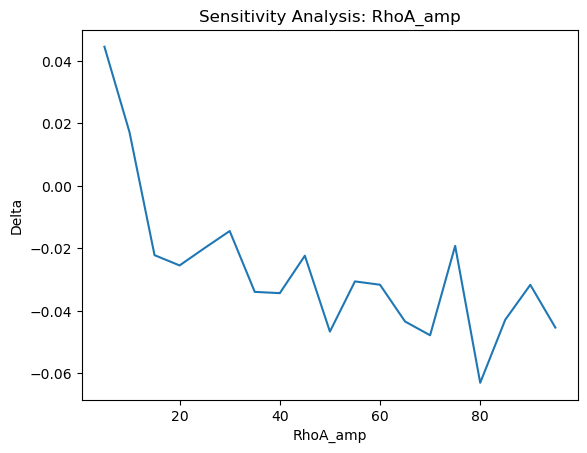

In [16]:
x = test_df["param_value"]
y = test_df["delta"]

plt.figure()

# Main delta curve
plt.plot(x, y)
plt.xlabel('RhoA_amp')
plt.ylabel("Delta")
plt.title(f"Sensitivity Analysis: RhoA_amp")
# plt.axhline(EPS, linestyle="--")
# plt.axhline(-EPS, linestyle="--")

## Manual 100 Sim Runs

how is it possible that convergence is at the same probabilities for all simulations??

In [50]:
perb_dict = {}
phenotype_dict = {}
#perbs_ss = []

# Run simulations. 
for name, mutation in PERBS_DICT.items():
    print(f"DEBUG: Running scenario: {name}")

    # Create model of KO scenario
    m = base_model.copy()
    for node, state in mutation.items():
        m.mutate(node, state)


    all_runs = []
    for i in range(N_RUNS):
        res = m.run()
        prob_df = res.get_last_nodes_probtraj()
        prob_df["run"] = i
        all_runs.append(prob_df)

    # Combine all runs
    prob_df = pd.concat(all_runs, ignore_index=True)

    # Compute Rho balance
    balance_df = prob_df.copy()
    balance_df["delta"] = compute_delta(balance_df)

    perb_dict[name] = balance_df
    
    # phenotype_df = classify_phenotype(balance_df)
    # phenotype_dict[name] = phenotype_df
    #print(phenotype_df)

DEBUG: Running scenario: WT
DEBUG: Running scenario: DSP
DEBUG: Running scenario: TJP1
DEBUG: Running scenario: JCAD
DEBUG: Running scenario: DSP_JCAD
DEBUG: Running scenario: TJP1_JCAD


In [54]:
dsp = perb_dict['DSP']
dsp['delta'].unique()

array([0.668165])

## Ensemble Moment

In [5]:

res = base_model.run()
base_model.get_initial_state()
ensemble = maboss.Ensemble(str(PROJECT_ROOT / "data" / "models"), str(MODELS_CFG), simulations=100)
ensemble.param['thread_count'] = 1
ensemble.print_cfg()


thread_count = 1;
DSP.is_internal = FALSE;
TJP1.is_internal = FALSE;
JCAD.is_internal = FALSE;
RhoA.is_internal = FALSE;
RhoC.is_internal = FALSE;



In [16]:

e = ensemble.copy()
e.mutate('DSP', 'OFF')

In [19]:
e.mutations
res = e.run()
prob_df = res.get_nodes_probtraj()
prob_df

,DSP,TJP1,RhoA,JCAD,RhoC
0.0,1.000000,1.000000,0.354098,1.000000,0.358173
0.1,1.000001,1.000001,0.691923,1.000001,0.695999
0.2,1.000000,1.000000,0.781404,1.000000,0.781084
0.3,1.000000,1.000000,0.804508,1.000000,0.804743
0.4,1.000000,1.000000,0.804364,1.000000,0.808941
...,...,...,...,...,...
49.5,1.000000,1.000000,0.802588,1.000000,0.810467
49.6,1.000000,1.000000,0.801073,1.000000,0.810740
49.7,1.000000,1.000000,0.802616,1.000000,0.812007
49.8,1.000000,1.000000,0.806200,1.000000,0.809442


In [ ]:
ensemble_dict = {}
ss_dict = {}
for name, mutation in PERBS_DICT.items():
    print(f"DEBUG: Running scenario: {name}")

    # Create model of KO scenario
    e = ensemble.copy()
    for node, state in mutation.items():
        e.mutate(node, state)

    # Run MaBoSS
    res = e.run()
    prob_df = res.get_nodes_probtraj().rename_axis('t').reset_index()
    
    # Compute Rho balance
    balance_df = prob_df.copy()  
    balance_df["delta"] = compute_delta(balance_df)
    ensemble_dict[name] = balance_df

    

    ss_df = res.get_last_nodes_probtraj()
    ss_dict[name] = ss_df

DEBUG: Running scenario: WT
DEBUG: Running scenario: DSP
thread_count = 1;
DSP.is_internal = FALSE;
TJP1.is_internal = FALSE;
JCAD.is_internal = FALSE;
RhoA.is_internal = FALSE;
RhoC.is_internal = FALSE;

DEBUG: Running scenario: TJP1
thread_count = 1;
DSP.is_internal = FALSE;
TJP1.is_internal = FALSE;
JCAD.is_internal = FALSE;
RhoA.is_internal = FALSE;
RhoC.is_internal = FALSE;

DEBUG: Running scenario: JCAD
thread_count = 1;
DSP.is_internal = FALSE;
TJP1.is_internal = FALSE;
JCAD.is_internal = FALSE;
RhoA.is_internal = FALSE;
RhoC.is_internal = FALSE;

DEBUG: Running scenario: DSP_JCAD
thread_count = 1;
DSP.is_internal = FALSE;
TJP1.is_internal = FALSE;
JCAD.is_internal = FALSE;
RhoA.is_internal = FALSE;
RhoC.is_internal = FALSE;

thread_count = 1;
DSP.is_internal = FALSE;
TJP1.is_internal = FALSE;
JCAD.is_internal = FALSE;
RhoA.is_internal = FALSE;
RhoC.is_internal = FALSE;

DEBUG: Running scenario: TJP1_JCAD
thread_count = 1;
DSP.is_internal = FALSE;
TJP1.is_internal = FALSE;
JCAD.

In [43]:
ensemble_dict['TJP1']

,t,DSP,TJP1,RhoA,JCAD,RhoC,delta
0,0.0,1.000000,1.000000,0.354098,1.000000,0.358173,0.004075
1,0.1,1.000001,1.000001,0.691923,1.000001,0.695999,0.004076
2,0.2,1.000000,1.000000,0.781404,1.000000,0.781084,-0.000320
3,0.3,1.000000,1.000000,0.804508,1.000000,0.804743,0.000235
4,0.4,1.000000,1.000000,0.804364,1.000000,0.808941,0.004577
...,...,...,...,...,...,...,...
495,49.5,1.000000,1.000000,0.802588,1.000000,0.810467,0.007879
496,49.6,1.000000,1.000000,0.801073,1.000000,0.810740,0.009667
497,49.7,1.000000,1.000000,0.802616,1.000000,0.812007,0.009391
498,49.8,1.000000,1.000000,0.806200,1.000000,0.809442,0.003242


In [40]:
ss_dict

{'WT':               DSP      JCAD      RhoA      RhoC      TJP1
 49.9000  0.999999  0.999999  0.806665  0.814914  0.999999,
 'DSP':               DSP      JCAD      RhoA      RhoC      TJP1
 49.9000  0.999999  0.999999  0.806665  0.814914  0.999999,
 'TJP1':               DSP      JCAD      RhoA      RhoC      TJP1
 49.9000  0.999999  0.999999  0.806665  0.814914  0.999999,
 'JCAD':               DSP      JCAD      RhoA      RhoC      TJP1
 49.9000  0.999999  0.999999  0.806665  0.814914  0.999999,
 'DSP_JCAD':               DSP      JCAD      RhoA      RhoC      TJP1
 49.9000  0.999999  0.999999  0.806665  0.814914  0.999999,
 'TJP1_JCAD':               DSP      JCAD      RhoA      RhoC      TJP1
 49.9000  0.999999  0.999999  0.806665  0.814914  0.999999}